2023-11-26

BBME 520

Assignment 11 part A

Javid Jannat

In [1]:
import numpy as np 
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from matplotlib import pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype= np.short) #gives 1 for females and 0 for males

data_n = output_variable.size
sets_n = 10

input_variables = [None]*sets_n

for i in range(sets_n):


    ROIS = (i+1)*100

    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=ROIS)
    print('%i regions found in this atlas' % (len(np.unique( nib.load(yeo.maps).get_fdata().ravel())) - 1))

    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps)


C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


100 regions found in this atlas
200 regions found in this atlas
300 regions found in this atlas
400 regions found in this atlas
500 regions found in this atlas
600 regions found in this atlas
700 regions found in this atlas
800 regions found in this atlas
900 regions found in this atlas
1000 regions found in this atlas


In [2]:
import sklearn
from sklearn import cross_decomposition
from sklearn import discriminant_analysis

trainers = [None]*3
trainers[0] = sklearn.cross_decomposition.PLSRegression(n_components=3)
trainers[1] = sklearn.cross_decomposition.CCA(n_components=1)
trainers[2] = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)

names = ['PLSR','CCA','LDA']

n_components=1 for CCa because we are trying to predict sexe which is 1 dimention.

Get following error otherwise : 'n_components' upper bound is 1. Got 2 instead. Reduce 'n_components'


In [3]:
#task 1

out = output_variable


insamp_accuracies = np.zeros((3,sets_n))

for i,inp in enumerate(input_variables):
    for j in range(3):
        model = trainers[j].fit(inp,out)
        prediction = model.predict(inp).flatten()
        prediction[prediction<0.5] = 0
        prediction[prediction>=0.5] = 1

        insamp_accuracies[j,i] = np.sum(prediction == out)/(out.size)

insamp_accuracies*=100

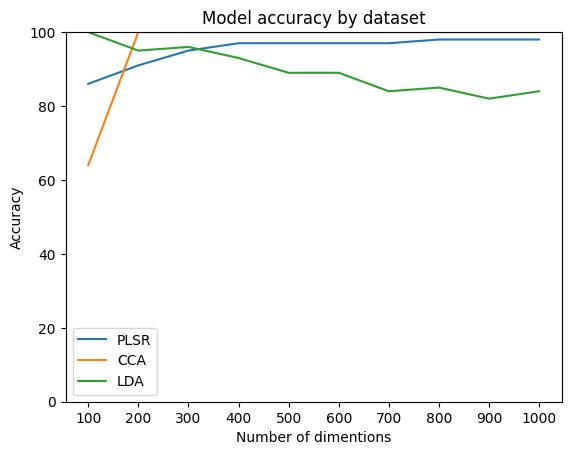

In [4]:
plt.plot(insamp_accuracies.transpose());
plt.legend(names)
plt.xlabel('Number of dimentions')
plt.xticks(np.arange(10),np.arange(100,1100,100));
plt.ylim([0,100])
plt.ylabel('Accuracy')
plt.title('Model accuracy by dataset');


In [5]:
#task 2

out = output_variable

EIGHTY = int(out.size*0.8)
linspace = np.arange(out.size)
train = linspace < EIGHTY
test = linspace >= EIGHTY

outsamp_accuracies = np.zeros((3,sets_n))
insamp_accuracies = np.zeros((3,sets_n))


splitter = sklearn.model_selection.KFold(n_splits=5, shuffle=False)

for i,inp in enumerate(input_variables):

    index_generator = splitter.split(inp,out)

    for (train,test) in index_generator:

        for j in range(3):

            model = trainers[j].fit(inp[train],out[train])

            prediction = model.predict(inp[test]).flatten()
            prediction[prediction<0.5] = 0
            prediction[prediction>=0.5] = 1
            outsamp_accuracies[j,i] += np.sum(prediction == out[test])/(out[test].size)

            prediction = model.predict(inp[train]).flatten()
            prediction[prediction<0.5] = 0
            prediction[prediction>=0.5] = 1
            insamp_accuracies[j,i] += np.sum(prediction == out[train])/(out[train].size)

outsamp_accuracies*=20
insamp_accuracies*=20

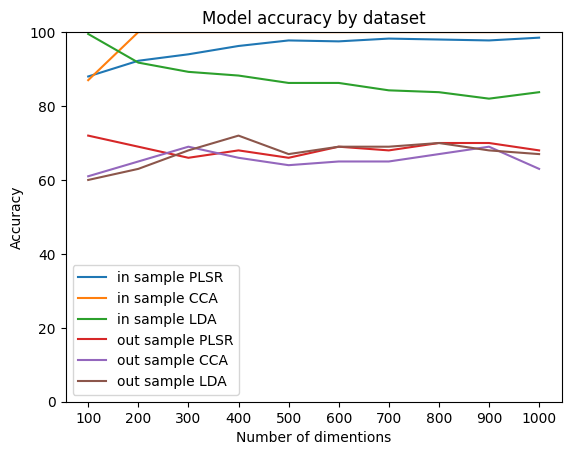

In [6]:
plt.plot(insamp_accuracies.transpose());
plt.plot(outsamp_accuracies.transpose());
plt.legend(['in sample PLSR','in sample CCA','in sample LDA','out sample PLSR','out sample CCA','out sample LDA'])

plt.xlabel('Number of dimentions')
plt.xticks(np.arange(10),np.arange(100,1100,100));
plt.ylim([0,100])
plt.ylabel('Accuracy')
plt.title('Model accuracy by dataset');

In [7]:
#task 3

out = output_variable

EIGHTY = int(out.size*0.8)
linspace = np.arange(out.size)
train = linspace < EIGHTY
test = linspace >= EIGHTY

outsamp_accuracies = np.zeros((3,sets_n))
insamp_accuracies = np.zeros((3,sets_n))


splitter = sklearn.model_selection.KFold(n_splits=5, shuffle=False)
pca_trainer = sklearn.decomposition.PCA(n_components=3)

for i,inp in enumerate(input_variables):

    index_generator = splitter.split(inp,out)

    for (train,test) in index_generator:

        for j in range(3):
            
            pca = pca_trainer.fit(inp[train])
            inp_train = pca.transform(inp[train])
            inp_test = pca.transform(inp[test])

            model = trainers[j].fit(inp_train,out[train])

            prediction = model.predict(inp_test).flatten()
            prediction[prediction<0.5] = 0
            prediction[prediction>=0.5] = 1
            outsamp_accuracies[j,i] += np.sum(prediction == out[test])/(out[test].size)

            prediction = model.predict(inp_train).flatten()
            prediction[prediction<0.5] = 0
            prediction[prediction>=0.5] = 1
            insamp_accuracies[j,i] += np.sum(prediction == out[train])/(out[train].size)

outsamp_accuracies*=20
insamp_accuracies*=20

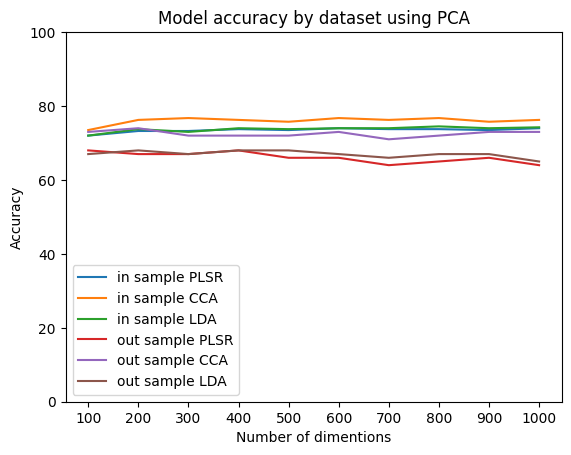

In [8]:
plt.plot(insamp_accuracies.transpose());
plt.plot(outsamp_accuracies.transpose());
plt.legend(['in sample PLSR','in sample CCA','in sample LDA','out sample PLSR','out sample CCA','out sample LDA'])

plt.xlabel('Number of dimentions')
plt.xticks(np.arange(10),np.arange(100,1100,100));
plt.ylim([0,100])
plt.ylabel('Accuracy')
plt.title('Model accuracy by dataset using PCA');

In [9]:
#task 4

out = output_variable

EIGHTY = int(out.size*0.8)
linspace = np.arange(out.size)
train = linspace < EIGHTY
test = linspace >= EIGHTY

splitter = sklearn.model_selection.KFold(n_splits=5, shuffle=False)

PLSR_coefs = 0
CCA_coefs = 0
LDA_coefs = 0

inp = input_variables[0]

index_generator = splitter.split(inp,out)

for (train,test) in index_generator:

    PLSR_model = trainers[0].fit(inp[train],out[train])
    PLSR_coefs += PLSR_model.x_loadings_/5

    CCA_model = trainers[1].fit(inp[train],out[train])
    CCA_coefs += CCA_model.x_loadings_/5

    LDA_model = trainers[2].fit(inp[train],out[train])
    LDA_coefs += LDA_model.coef_/5


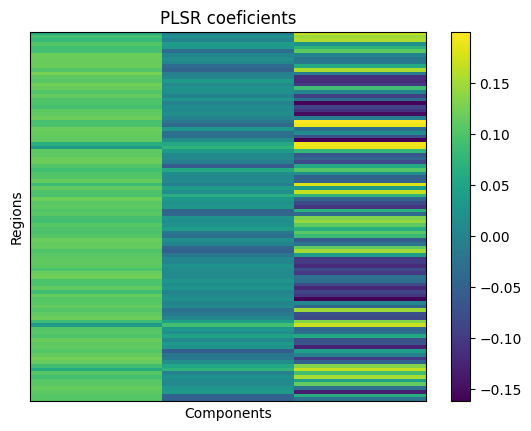

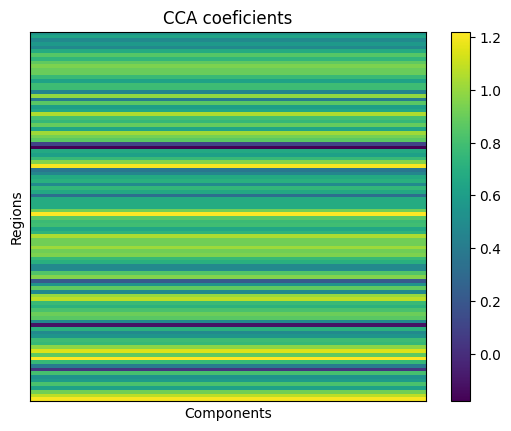

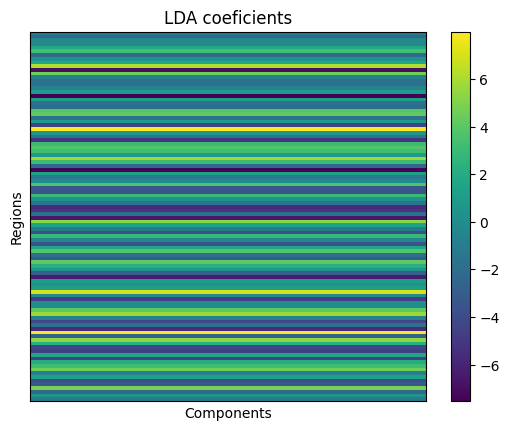

In [10]:
plt.imshow(PLSR_coefs, interpolation='nearest', aspect='auto');
plt.xticks([])
plt.yticks([])
plt.title('PLSR coeficients')
plt.xlabel('Components')
plt.ylabel('Regions')
plt.colorbar()
plt.show()
plt.imshow(CCA_coefs, interpolation='nearest', aspect='auto');
plt.xticks([])
plt.yticks([])
plt.title('CCA coeficients')
plt.xlabel('Components')
plt.ylabel('Regions')
plt.colorbar()
plt.show()
plt.imshow(LDA_coefs.reshape(100,1), interpolation='nearest', aspect='auto');
plt.xticks([])
plt.yticks([])
plt.title('LDA coeficients')
plt.xlabel('Components')
plt.ylabel('Regions')
plt.colorbar()
plt.show()

In [11]:
#task 5

out = output_variable

EIGHTY = int(out.size*0.8)
linspace = np.arange(out.size)
train = linspace < EIGHTY
test = linspace >= EIGHTY

splitter = sklearn.model_selection.KFold(n_splits=5, shuffle=False)
pca_trainer = sklearn.decomposition.PCA(n_components=3)

PLSR_coefs = 0
CCA_coefs = 0
LDA_coefs = 0

inp = input_variables[0]

index_generator = splitter.split(inp,out)

for (train,test) in index_generator:


    pca = pca_trainer.fit(inp[train])
    inp_train = pca.transform(inp[train])
    inp_test = pca.transform(inp[test])

    PLSR_model = trainers[0].fit(inp_train,out[train])
    PLSR_coefs += PLSR_model.x_loadings_/5

    CCA_model = trainers[1].fit(inp_train,out[train])
    CCA_coefs += CCA_model.x_loadings_/5

    LDA_model = trainers[2].fit(inp_train,out[train])
    LDA_coefs += LDA_model.coef_/5


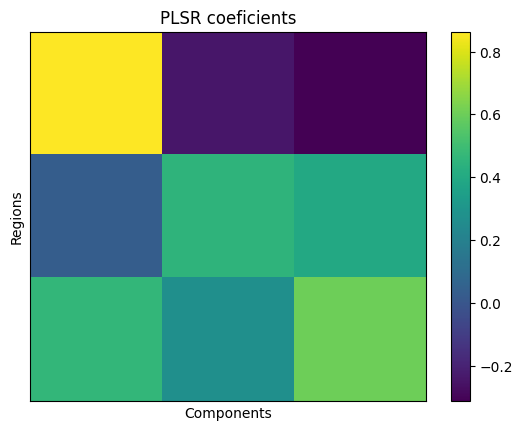

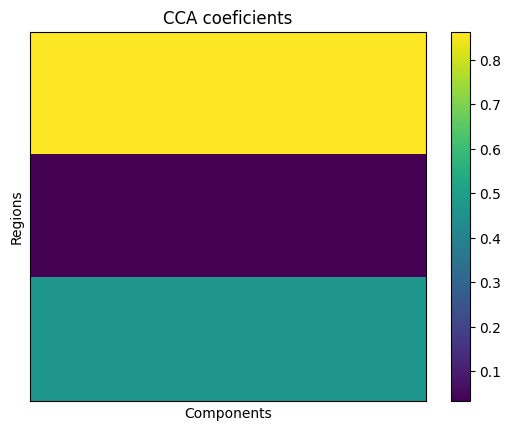

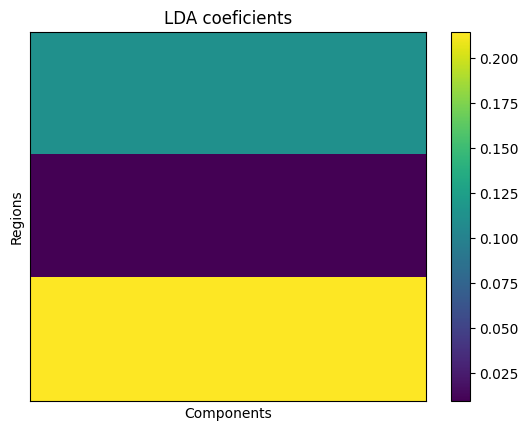

In [12]:
plt.imshow(PLSR_coefs, interpolation='nearest', aspect='auto');
plt.xticks([])
plt.yticks([])
plt.title('PLSR coeficients')
plt.xlabel('Components')
plt.ylabel('Regions')
plt.colorbar()
plt.show()
plt.imshow(CCA_coefs, interpolation='nearest', aspect='auto');
plt.xticks([])
plt.yticks([])
plt.title('CCA coeficients')
plt.xlabel('Components')
plt.ylabel('Regions')
plt.colorbar()
plt.show()
plt.imshow(LDA_coefs.reshape(3,1), interpolation='nearest', aspect='auto');
plt.xticks([])
plt.yticks([])
plt.title('LDA coeficients')
plt.xlabel('Components')
plt.ylabel('Regions')
plt.colorbar()
plt.show()